## BASE SENSITIVITY ANALYSIS

In [290]:
import dolfin as dolf
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

from helmholtz_pkg.passive_flame import PassiveFlame
from helmholtz_pkg.flame_transfer_function import n_tau
from helmholtz_pkg.active_flame import ActiveFlame
from helmholtz_pkg.eigensolvers import fixed_point_iteration_pep, pep_solver
from helmholtz_pkg.eigenvectors import normalize_eigenvector, normalize_adjoint
from helmholtz_pkg.petsc4py_utils import vector_matrix_vector, vector_vector, conjugate
import params
from active_flame_derivative import derivativeD, derivativeA

## Speed of Sound Distribution

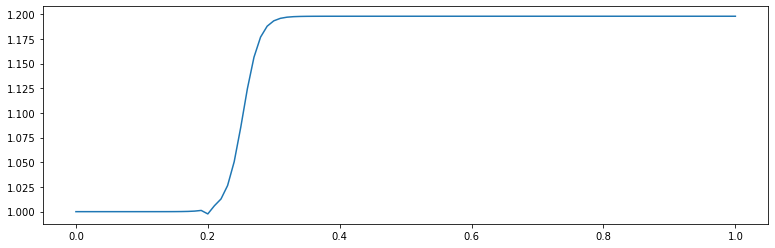

In [319]:
string_f_1d = '1 / (sigma * sqrt(2*pi)) * exp(- pow(x[0] - x_0, 2) / (2 * pow(sigma, 2)) )'
a_f = 0.0005 # 0.0005
v = dolf.Expression(string_f_1d, degree=0, x_0=params.x_f[0][0], sigma=a_f)
# w = dolf.Expression(string_f_1d, degree=0, x_0=x_r[0][0], sigma=a_r)
c_p = dolf.Expression(string_f_1d, degree=0, x_0=params.x_r[0][0], sigma=a_f)

c_perturbed = dolf.Expression("sqrt(gamma*p_amb/rho)-0.0000063*perturbation", degree = 1,#-0.0000063
               gamma = params.gamma,
               p_amb = params.p_amb/params.p_ref,
               rho = params.rho,
               perturbation = c_p) # Variable Speed of sound (m,/s)

mesh1 = dolf.UnitIntervalMesh(100)
V1 = dolf.FunctionSpace(mesh1, 'CG', 1)
c_plot = dolf.interpolate(c_perturbed, V1)
dolf.plot(c_plot)

In [320]:
plt.rcParams['figure.figsize'] = [13, 4]

In [321]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)

    return mesh, boundaries, subdomains

In [332]:
degree = 1

mesh, boundaries, subdomains = mshr(400)

boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                        2: {'Robin': params.Y_out}}  # outlet

foo = PassiveFlame(mesh, boundaries, boundary_conditions,
                    c=c_perturbed,
                    degree=degree)
foo.assemble_A()
foo.assemble_B()
foo.assemble_C()

ftf = n_tau(params.n, params.tau)

D = ActiveFlame(mesh, subdomains,
                params.x_f, params.x_r, params.rho_in, 1., 1., ftf,
                degree=degree)

D.assemble_submatrices(problem_type='direct')
D.assemble_submatrices(problem_type='adjoint')

E_dir = fixed_point_iteration_pep(foo, D, pi, nev=2, i=0, problem_type='direct',tol=1e-13, maxiter=100)
E_adj = fixed_point_iteration_pep(foo, D, pi, nev=2, i=1, problem_type='adjoint',tol=1e-13, maxiter=100)

omega_dir, p_dir = normalize_eigenvector(mesh, E_dir, i=0, degree=degree, which='right')
omega_adj, p_adj = normalize_eigenvector(mesh, E_adj, i=1, degree=degree, which='left')
print(omega_dir, omega_adj)

p_dir_r, p_dir_i = p_dir.split()
p_adj_r, p_adj_i = p_adj.split()

iter =  1,  omega = +3.4275185071244  +0.0144424436705j,  |domega| = 1.29e-02
iter =  2,  omega = +3.4253383607767  +0.0021365037977j,  |domega| = 1.25e-02
iter =  3,  omega = +3.4253386649882  +0.0021376612393j,  |domega| = 1.20e-06
iter =  4,  omega = +3.4253386649692  +0.0021376611859j,  |domega| = 5.67e-11
iter =  5,  omega = +3.4253386649692  +0.0021376611859j,  |domega| = 7.55e-15
iter =  1,  omega = +3.4275185071244  -0.0144424436705j,  |domega| = 1.29e-02
iter =  2,  omega = +3.4253383607767  -0.0021365037977j,  |domega| = 1.25e-02
iter =  3,  omega = +3.4253386649883  -0.0021376612393j,  |domega| = 1.20e-06
iter =  4,  omega = +3.4253386649692  -0.0021376611859j,  |domega| = 5.67e-11
iter =  5,  omega = +3.4253386649693  -0.0021376611859j,  |domega| = 1.78e-14
Normalization relation is | p p dx = 1 
Normalization relation is | p p dx = 1 
(3.4253386649691984+0.002137661185864015j) (3.425338664969267-0.0021376611858662385j)


In [333]:
# BASE STATE SENSITIVITY ------------------------------------------------------------------------------------------

p_dir_vec = p_dir.vector().vec()
p_adj_vec = p_adj.vector().vec()

dLds = foo.B + foo.assemble_zC(2 * omega_dir) - D.get_derivative(omega_dir)

denominator = -vector_matrix_vector(p_adj_vec, dLds , p_dir_vec )
#denominator = denominator.conjugate()
print(denominator)

Calling FFC just-in-time (JIT) compiler, this may take some time.
(-6.8378208524970985+0.03581274236257534j)


In [334]:
# deltaA = derivativeA(foo)
# deltaA.derivative_c()
def c_form(mesh, degree):

        
    CG = dolf.FiniteElement('CG', mesh.ufl_cell(), degree = degree)
    W  = dolf.FunctionSpace(mesh, CG*CG)
    dofmap = W.dofmap()


    (u_1, u_2) = dolf.TrialFunction(W)
    (v_1, v_2) = dolf.TestFunction(W)
    dx = dolf.Measure('dx', domain = mesh)
    da_11 = -2 * c_perturbed * dolf.dot(dolf.grad(v_1), dolf.grad(u_1)) * dx
    da_22 = -2 * c_perturbed * dolf.dot(dolf.grad(v_2), dolf.grad(u_2)) * dx
        
    da = da_11 + da_22
    
    return dofmap, da
deltaD = derivativeD(D, D.submatrices)
deltaD.derivative_c(omega_dir)

## MATRIX D CONTRIBUTION CONSIDERED

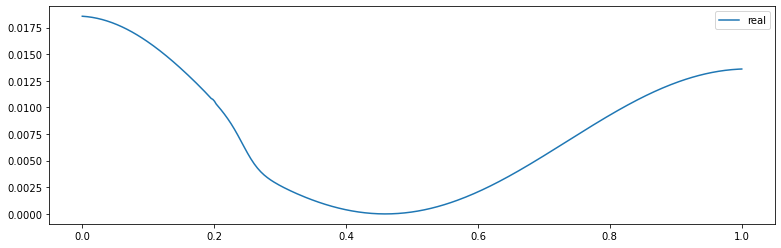

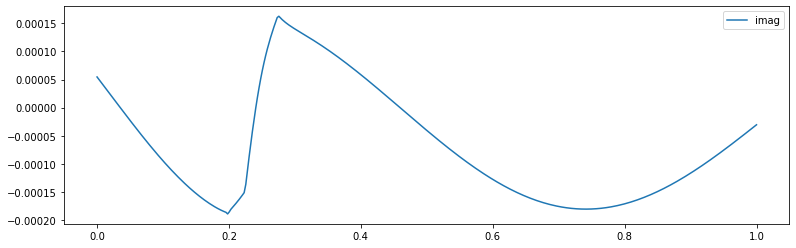

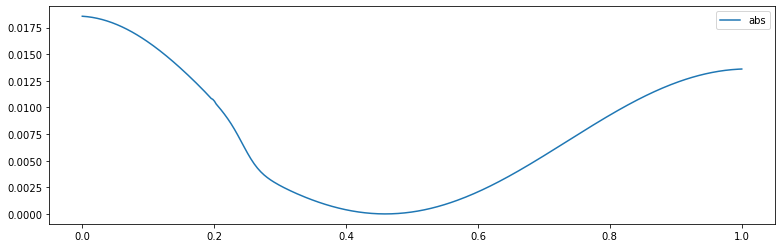

In [335]:
dofmap, a = c_form(mesh, degree)
ds_dc = np.zeros(mesh.num_vertices()-1,dtype=complex)
for i, cell in enumerate(dolf.cells(mesh)):
    # Assemble locally the derivative dLdc for the corresponding cell
    dLdc = dolf.assemble_local(a , cell) # calculate stiffness matrix at cell

    # Finding the dof's indices in the current cell
    indices = dofmap.cell_dofs(cell.index())
    # Calculating left and right eigenvectors for current cell by using indices
    p_left = p_adj.vector()[indices]
    p_right = p_dir.vector()[indices]
    
    def real_to_complex(p,conjugate = 'no'):
        p_r = np.array(p[0:int(len(p)/2)])   # get the real part of vector
        p_i = 1j*np.array(p[int(len(p)/2):]) # get the imag part of vector
        if conjugate == 'yes':
            p_c = p_r - p_i # if it is adjoint vector at that cell
        else:
            p_c = p_r + p_i # if it is direct vector at that cell
        return p_c
    
    p_left = real_to_complex(p_left,conjugate = 'yes') # Taking the conjugate of adjoint vector
    p_right = real_to_complex(p_right)
    # Determine nominator = p_left * dLdc * p_right
    dLdc = dLdc[0:2,0:2]+0j # Take the top left corner of dLdc since it has not complex part
    numerator = np.dot(np.transpose(p_left), (np.dot(dLdc , p_right)))
    if cell.index() == 79: # Calculate the contribution of Matrix D at reference cell x_r
        numerator -= vector_matrix_vector(p_adj_vec , deltaD.c , p_dir_vec )
    # Append the result to the numpy array (denominator was calculated before and same everywhere)
    ds_dc[i] = numerator / denominator


plt.plot(np.linspace(0,1,400),ds_dc.real,label = "real")
plt.legend()
plt.show()
plt.plot(np.linspace(0,1,400),ds_dc.imag,label = "imag")
plt.legend()
plt.show()
plt.plot(np.linspace(0,1,400),abs(ds_dc),label = "abs")
plt.legend()
plt.show()

## MATRIX D NOT CONSIDERED

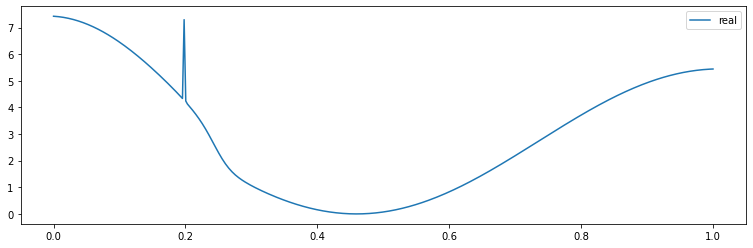

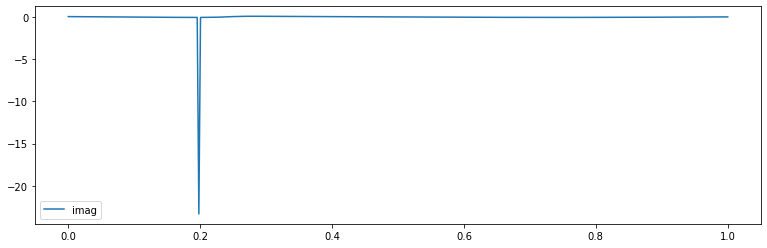

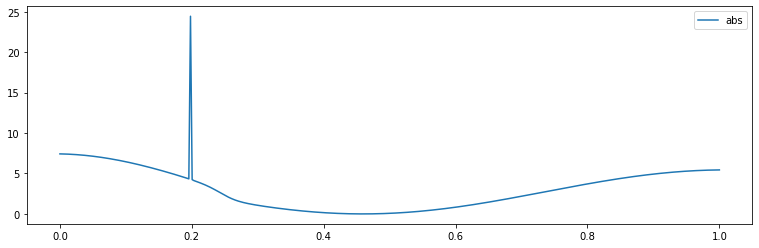

In [298]:
dofmap = deltaA.function_space.dofmap()
ds_dc_noD = np.zeros(mesh.num_vertices()-1,dtype=complex)
dL_dc = []
for i, cell in enumerate(dolf.cells(mesh)):
    # Assemble locally the derivative dLdc for the corresponding cell
    dLdc = dolf.assemble_local(deltaA.c_form , cell) # calculate stiffness matrix at cell
    dL_dc.append(dLdc)
    # Finding the dof's indices in the current cell
    indices = dofmap.cell_dofs(cell.index())
    # Calculating left and right eigenvectors for current cell by using indices
    p_left = p_adj.vector()[indices]
    p_right = p_dir.vector()[indices]
    
    def real_to_complex(p,conjugate = 'no'):
        p_r = np.array(p[0:int(len(p)/2)])   # get the real part of vector
        p_i = 1j*np.array(p[int(len(p)/2):]) # get the imag part of vector
        if conjugate == 'yes':
            p_c = p_r - p_i # if it is adjoint vector at that cell
        else:
            p_c = p_r + p_i # if it is direct vector at that cell
        return p_c
    
    p_left = real_to_complex(p_left,conjugate = 'yes') # Taking the conjugate of adjoint vector
    p_right = real_to_complex(p_right)
    # Determine nominator = p_left * dLdc * p_right
    dLdc = dLdc[0:2,0:2]+0j # Take the top left corner of dLdc since it has not complex part
    numerator = np.dot(np.transpose(p_left), (np.dot(dLdc , p_right)))
#     if cell.index() == 79: # Calculate the contribution of Matrix D at reference cell x_r
#         nominator -= vector_matrix_vector(p_adj_vec , deltaD.c , p_dir_vec )
    # Append the result to the numpy array (denominator was calculated before and same everywhere)
    ds_dc_noD[i] = numerator / denominator*400

plt.plot(np.linspace(0,1,400),ds_dc_noD.real,label = "real")
plt.legend()
plt.show()
plt.plot(np.linspace(0,1,400),ds_dc_noD.imag,label = "imag")
plt.legend()
plt.show()
plt.plot(np.linspace(0,1,400),abs(ds_dc_noD),label = "abs")
plt.legend()
plt.show()

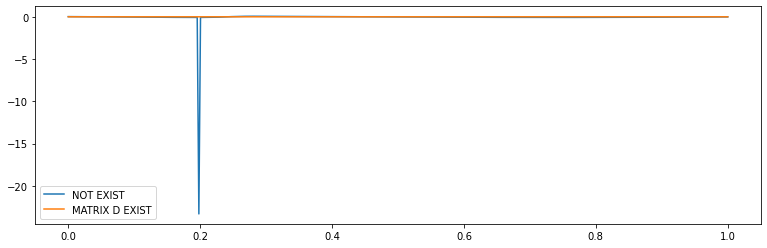

In [299]:
plt.plot(np.linspace(0,1,400),ds_dc_noD.imag,label = "NOT EXIST")
plt.plot(np.linspace(0,1,400),ds_dc.imag,label = "MATRIX D EXIST")
# plt.ylim([0])
plt.legend()

## NORMALIZE_ADJOINT USAGE

In [300]:
dofmap = deltaA.function_space.dofmap()
ds_dc = np.zeros(mesh.num_vertices()-1,dtype=complex)
dL_dc = []
for i, cell in enumerate(dolf.cells(mesh)):
    # Assemble locally the derivative dLdc for the corresponding cell
    dLdc = dolf.assemble_local(deltaA.c_form , cell) # calculate stiffness matrix at cell
    dL_dc.append(dLdc)
    # Finding the dof's indices in the current cell
    indices = dofmap.cell_dofs(cell.index())
    # Calculating left and right eigenvectors for current cell by using indices
    p_left = p_adj.vector()[indices]
    p_right = p_dir.vector()[indices]
    
    def real_to_complex(p,conjugate = 'no'):
        p_r = np.array(p[0:int(len(p)/2)])   # get the real part of vector
        p_i = 1j*np.array(p[int(len(p)/2):]) # get the imag part of vector
        if conjugate == 'yes':
            p_c = p_r - p_i # if it is adjoint vector at that cell
        else:
            p_c = p_r + p_i # if it is direct vector at that cell
        return p_c
    
    p_left = real_to_complex(p_left,conjugate = 'yes') # Taking the conjugate of adjoint vector
    p_right = real_to_complex(p_right)
    # Determine nominator = p_left * dLdc * p_right
    dLdc = dLdc[0:2,0:2]+0j # Take the top left corner of dLdc since it has not complex part
    nominator = np.dot(np.transpose(p_left), (np.dot(dLdc , p_right)))
    ds_dc[i] = nominator / denominator

    if cell.index() == 79:
        print(ds_dc[i])
        value = normalize_adjoint(omega_dir, p_dir, p_adj, foo, D).vector().vec() # p_adj/denominator
        contribution = -vector_matrix_vector(value , deltaD.c , p_dir_vec ) # -p_adj*dDdc*p_dir/denominator 
        print("Contribution: ", contribution)
        ds_dc[i] += contribution
        print(ds_dc[i])

(0.018243386391291288-0.058337664815029396j)
Contribution:  (0.007445115753921116-0.05800234327091243j)
(0.025688502145212403-0.11634000808594183j)


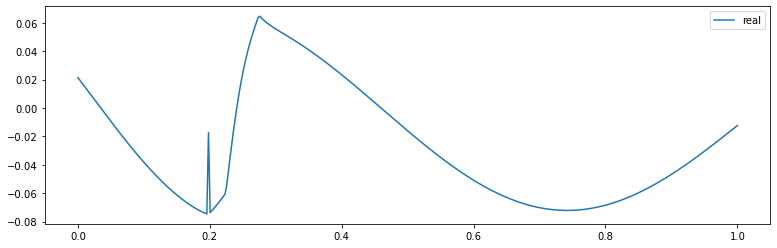

In [301]:
#plt.plot(np.linspace(0,1,400),abs(ds_dc),label = "abs")
#plt.plot(np.linspace(0,1,400),ds_dc.imag,label = "imag")
# plt.plot(np.linspace(0,1,400),ds_dc.imag,label = "real")
plt.plot(np.linspace(0,1,400),ds_dc_w.imag,label = "real")

plt.legend()

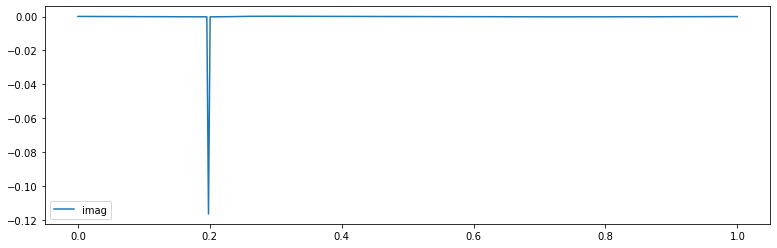

In [302]:
plt.plot(np.linspace(0,1,400),ds_dc.imag,label = "imag")
plt.legend()

## Specific Density

In [303]:
conversion = 1/2*(params.gamma*params.p_amb*(1/params.rho_in))**(-1/2)*params.gamma*params.p_amb
print("conversion coefficient from delta c to delta v: ", conversion)
ds_dv = ds_dc*conversion

conversion coefficient from delta c to delta v:  221.35943621178654


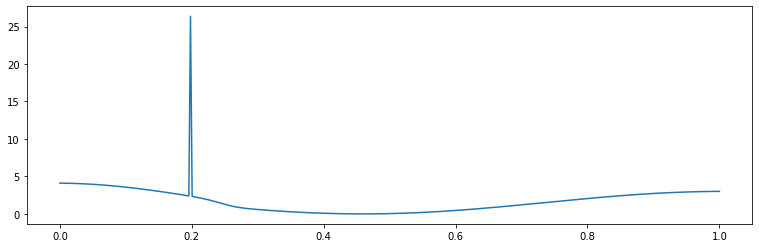

In [304]:
plt.plot(np.linspace(0,1,400),abs(ds_dv))